## DEGs CD8 Naive T cells

In [1]:

# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(lme4)
quiet_library(ggpubr)
quiet_library(ggrepel)
quiet_library(ggthemes)
options(warn = -1)

In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")
coolors_clrs<-c("#EFB0A1","#009FF5","#1A5E9B","#42E2B8","#4ECDC4","#89B6A5","#F1D26A","#D5B0AC","#EDABB1","#02504D","#AA9674","#E64B35FF","#4DBBD5FF","#00A087FF")

cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width =5, repr.plot.height =5)

In [4]:
fig_path="/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Fig6/"

In [5]:
# Function to generate a volcano plot with customized settings
# 
# This function creates a volcano plot from gene expression data, highlighting significant genes 
# with specific colors based on their log fold change and adjusted p-values. It includes options 
# for customizing plot labels, axis limits, and saving the plot to a specified file path.
#
# Parameters:
# - data: The main data frame containing the gene expression data.
# - logfc_column: The name of the column in 'data' representing log fold change.
# - pval_column: The name of the column in 'data' representing p-values.
# - padj_column: The name of the column in 'data' representing adjusted p-values.
# - gene_column: The name of the column in 'data' representing gene names.
# - filtered_genes: A data frame containing a subset of genes to be highlighted on the plot.
# - title: The title of the volcano plot.
# - x_label: The label for the x-axis.
# - y_label: The label for the y-axis.
# - x_limits: A numeric vector of length 2 specifying the range of the x-axis (optional).
# - y_limits: A numeric vector of length 2 specifying the range of the y-axis (optional).
# - file_path: The directory path where the plot should be saved (optional).
# - file_name: The name of the file to save the plot as (optional).
# - max_overlaps: The maximum number of overlapping text labels allowed by geom_text_repel (default is 20).

plot_custom_volcano <- function(data, logfc_column, pval_column, padj_column, gene_column, filtered_genes, 
                         title, x_label, y_label, x_limits = NULL, y_limits = NULL, file_path = NULL, file_name = NULL,max_overlaps) {
  # Custom color mapping based on log fold change and padj significance
  data$sig_color <- ifelse(data[[padj_column]] > 0.1, '#595959', #davy's grey
                           ifelse(data[[logfc_column]] < 0 & data[[padj_column]] < 0.1, '#F59F00',
                                  ifelse(data[[logfc_column]] > 0 & data[[padj_column]] < 0.1, '#840032', '#595959')))
  # Print total number of genes
  total_genes <- nrow(data)

    p <- ggplot(data, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")"), color = "sig_color")) +
    geom_point(size = 3, alpha = 0.5,stroke=0) +  # Adjust size and transparency
    geom_hline(yintercept = 1, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed") +  # Add significance threshold line
    labs(x = x_label, y = y_label, title = title) +  # Labels and title
    theme_minimal() +  # Minimal theme
    geom_point(data = filtered_genes, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")")), 
               fill = "005E7A",color="black",size = 3, shape = 21, stroke = .5) +  # Overlay the filtered genes
    geom_text_repel(data = filtered_genes, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")"), label = gene_column),
                    hjust = -0.4, vjust = -0.7, size = 5,color = "black",segment.size = .5, segment.color = "black", max.overlaps = max_overlaps,min.segment.length = 0) + # Add gene labels
    scale_color_manual(values = c("#595959" = "#595959", "#F59F00" = "#F59F00", "#840032" = "#840032")) + 
    # Manual color scale
    theme_few()+
    theme(legend.position = "none")+  # Remove the legend
     annotate("text", x = Inf, y = -Inf, label = paste("Total genes:", total_genes), hjust = 1, vjust = -1,
             color = "black", size = 5)
      
  
  # Set x and y axis limits if specified
  if (!is.null(x_limits)) {
    p <- p + xlim(x_limits)
  }
  if (!is.null(y_limits)) {
    p <- p + ylim(y_limits)
  }
  
  # Save the plot if file_path and file_name 
  if (!is.null(file_path) & !is.null(file_name)) {
    full_path <- file.path(file_path, file_name)
    ggsave(full_path, plot = p, width = 5, height = 5)
  }
  
  print(p)
}
# usage
# plot_custom_volcano(data = deg_a3, logfc_column = "logfc_by_year", pval_column = "p.value", 
#              padj_column = "padj", gene_column = "gene", filtered_genes = filtered_df_gene, 
#              title = "Core Naive CD4 T cells", x_label = "log2FC by year", y_label = "-log10(padj)",
#              x_limits = c(-0.8,0.8), y_limits = c(0.5, 2), max_overlaps = 35,
#              file_path = fig_path, file_name = "Fig_6A_CD4_naive_volcano_plot.pdf")

In [6]:
## read the AIM 3 deg results 
deg_a3=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/certpro_Zi_files/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3_mixed_models_time_result_750days.csv")
deg_a3%>%dim
deg_a3%>%head(3)

[1] 267913     12

,celltype,effect,group,term,estimate,std.error,statistic,df,p.value,gene,q_values,sig
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,Adaptive NK cell,fixed,NA,days_to_conversion,-4.601178e-04,0.0001726325,-2.6653027,43.00000,0.01079008,AAK1,0.3471929,ns
2,Adaptive NK cell,fixed,NA,days_to_conversion,2.698218e-04,0.0001816877,1.4850857,43.00000,0.14481591,AASDHPPT,0.5004335,ns
3,Adaptive NK cell,fixed,NA,days_to_conversion,-1.742457e-05,0.0001246150,-0.1398272,42.98683,0.88944965,AATF,0.7853112,ns


In [7]:
# filter CD8 Naive cell type 
deg_a3=deg_a3%>%filter(celltype=="Core naive CD8 T cell")
deg_a3%>%dim
deg_a3%>%head(3)

[1] 5622   12

,celltype,effect,group,term,estimate,std.error,statistic,df,p.value,gene,q_values,sig
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,Core naive CD8 T cell,fixed,NA,days_to_conversion,-0.0003365060,0.0001393532,-2.4147715,42.52827,0.020121284,A1BG,0.12488167,<0.2
2,Core naive CD8 T cell,fixed,NA,days_to_conversion,-0.0000390451,0.0001720038,-0.2270014,46.00000,0.821428504,AAK1,0.46523124,ns
3,Core naive CD8 T cell,fixed,NA,days_to_conversion,-0.0003630197,0.0001186396,-3.0598518,44.53345,0.003743043,AAMP,0.07717608,<0.2


In [8]:
# customised genes to plot 
genes_to_plot <- c("CD3G", "CD3D", "CD3E", "CD247", "STAT2", "STAT5B", "STAT4", "MAF", "STIM2", 
           "ICOS", "CD28", "EGR1", "FOS", "FOSB", "AKT3", "IL6ST", "GRAP2", "NFAT5", 
           "STAT6", "STIM1", "RORA", "NFKB1", "IKBKB", "JUN", "TRAF5", "IL10RA", 
           "PTPN4", "TCF7", "RAF1", "CASP8")


In [9]:
##renaming the columns to plot 

deg_a3 <- deg_a3 %>%
  rename(
    log2FoldChange = estimate,
    padj = q_values
  )
deg_a3%>%head(2)

,celltype,effect,group,term,log2FoldChange,std.error,statistic,df,p.value,gene,padj,sig
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.36506e-04,0.0001393532,-2.4147715,42.52827,0.02012128,A1BG,0.1248817,<0.2
2,Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.90451e-05,0.0001720038,-0.2270014,46.00000,0.82142850,AAK1,0.4652312,ns


In [11]:
#adjusting the log2FC scale by multiplying by 365(1year) 
deg_a3 <- deg_a3 %>%
  mutate(logfc_by_year= log2FoldChange * 365)
deg_a3%>%head(2)

,celltype,effect,group,term,log2FoldChange,std.error,statistic,df,p.value,gene,padj,sig,logfc_by_year
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.36506e-04,0.0001393532,-2.4147715,42.52827,0.02012128,A1BG,0.1248817,<0.2,-0.12282470
2,Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.90451e-05,0.0001720038,-0.2270014,46.00000,0.82142850,AAK1,0.4652312,ns,-0.01425146


In [12]:
# filtering genes from deg_a3 based on custom genes_to_plot
deg_a3_filtered=deg_a3 %>% filter(gene %in% genes_to_plot)
deg_a3_filtered


celltype,effect,group,term,log2FoldChange,std.error,statistic,df,p.value,gene,padj,sig,logfc_by_year
<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
Core naive CD8 T cell,fixed,NA,days_to_conversion,5.909115e-04,1.967237e-04,3.0037641,45.90047,4.307739e-03,AKT3,0.07972531,<0.2,0.21568271
Core naive CD8 T cell,fixed,NA,days_to_conversion,5.047967e-04,1.404996e-04,3.5928694,43.73401,8.244061e-04,CASP8,0.05525159,<0.2,0.18425081
Core naive CD8 T cell,fixed,NA,days_to_conversion,-2.811464e-04,1.136197e-04,-2.4744511,44.74924,1.720227e-02,CD247,0.11559314,<0.2,-0.10261845
Core naive CD8 T cell,fixed,NA,days_to_conversion,2.680737e-04,1.575735e-04,1.7012612,42.40663,9.621651e-02,CD28,0.18535452,<0.2,0.09784690
Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.052838e-04,1.146512e-04,-2.6627173,45.64048,1.066953e-02,CD3D,0.10002358,<0.2,-0.11142860
Core naive CD8 T cell,fixed,NA,days_to_conversion,-2.163710e-04,9.749214e-05,-2.2193690,45.97931,3.143510e-02,CD3E,0.13459422,<0.2,-0.07897543
Core naive CD8 T cell,fixed,NA,days_to_conversion,-3.589835e-04,8.921899e-05,-4.0236217,40.39603,2.447929e-04,CD3G,0.05525159,<0.2,-0.13102897
Core naive CD8 T cell,fixed,NA,days_to_conversion,1.352590e-03,7.521886e-04,1.7982052,44.10057,7.899188e-02,EGR1,0.17153714,<0.2,0.49369518
Core naive CD8 T cell,fixed,NA,days_to_conversion,1.612655e-03,8.162011e-04,1.9758065,44.01381,5.446655e-02,FOS,0.15304708,<0.2,0.58861919


In [13]:
# filtering the significant genes from the custom genes to plot 
filtered_genes <- deg_a3_filtered %>% 
  filter(p.value <0.05 & padj < 0.1) %>% 
  pull(gene)
filtered_genes
filtered_genes%>%length

[1] "AKT3"   "CASP8"  "CD3G"   "IL10RA" "NFKB1"  "PTPN4"  "STAT5B" "STIM2" 
[9] "TRAF5"

[1] 9

In [14]:
#subsetting the significant genes as df 
# Filter from  deg_a3 dataframe to include only the  filtered_genes to plot whos padj<0.1
filtered_df_gene <- deg_a3_filtered[deg_a3_filtered$gene %in% filtered_genes, ]
filtered_df_gene%>%head()
filtered_df_gene%>%dim

,celltype,effect,group,term,log2FoldChange,std.error,statistic,df,p.value,gene,padj,sig,logfc_by_year
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,Core naive CD8 T cell,fixed,NA,days_to_conversion,0.0005909115,1.967237e-04,3.003764,45.90047,4.307739e-03,AKT3,0.07972531,<0.2,0.2156827
2,Core naive CD8 T cell,fixed,NA,days_to_conversion,0.0005047967,1.404996e-04,3.592869,43.73401,8.244061e-04,CASP8,0.05525159,<0.2,0.1842508
7,Core naive CD8 T cell,fixed,NA,days_to_conversion,-0.0003589835,8.921899e-05,-4.023622,40.39603,2.447929e-04,CD3G,0.05525159,<0.2,-0.1310290
13,Core naive CD8 T cell,fixed,NA,days_to_conversion,0.0003792882,1.187153e-04,3.194939,38.63024,2.784614e-03,IL10RA,0.07465515,<0.2,0.1384402
17,Core naive CD8 T cell,fixed,NA,days_to_conversion,0.0004449581,1.513681e-04,2.939577,41.18598,5.367734e-03,NFKB1,0.08206516,<0.2,0.1624097
18,Core naive CD8 T cell,fixed,NA,days_to_conversion,0.0005062691,1.026667e-04,4.931192,45.99314,1.107278e-05,PTPN4,0.01058800,*,0.1847882


[1]  9 13

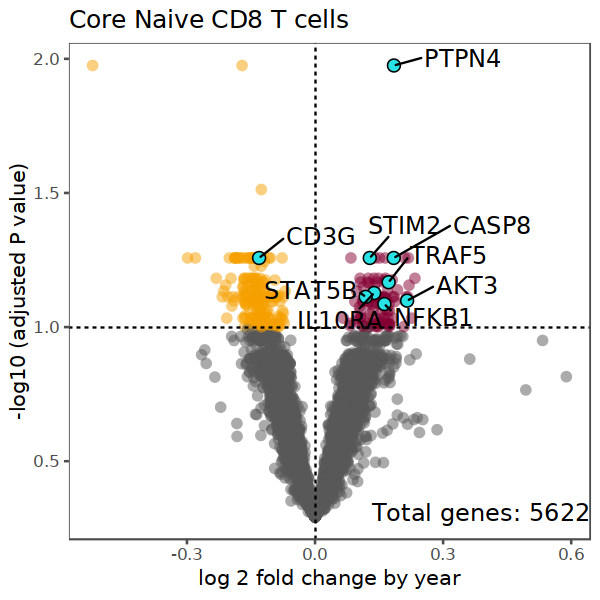

In [15]:
plot_custom_volcano(data = deg_a3, logfc_column = "logfc_by_year", pval_column = "p.value", 
             padj_column = "padj", gene_column = "gene", filtered_genes = filtered_df_gene, 
             title = "Core Naive CD8 T cells", x_label = "log 2 fold change by year", y_label = "-log10 (adjusted P value)",
             #x_limits = c(-0.5,0.5), y_limits = c(0.3, 2),
                    max_overlaps = 35,
             file_path = fig_path, file_name = "Fig_5B.pdf"
                   )

In [16]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggthemes_5.1.0              ggrepel_0.9.5              
 [3] lme4_1.1-34                 plotly_4.10.4              
 [5] knitr_1.47                  ggpubr_0.6.0               
 [7] SeuratDisk_0.0.0.9021       SingleCellExperiment_1.22.0
 [9] SummarizedExperiment_1.30.2 Biobas